In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
#hide
from fastbook import *

# Collaborative Filtering Deep Dive


# 协作过滤深潜[机器翻译]

One very common problem to solve is when you have a number of users and a number of products, and you want to recommend which products are most likely to be useful for which users. There are many variations of this: for example, recommending movies (such as on Netflix), figuring out what to highlight for a user on a home page, deciding what stories to show in a social media feed, and so forth. There is a general solution to this problem, called *collaborative filtering*, which works like this: look at what products the current user has used or liked, find other users that have used or liked similar products, and then recommend other products that those users have used or liked.


需要解决的一个非常常见的问题是，当您有许多用户和产品，并且您想要推荐哪些产品最有可能对哪些用户有用时。这有许多变化: 例如，推荐电影 (例如在Netflix上)，在主页上为用户突出显示什么，决定在社交媒体提要中展示哪些故事，等等。这个问题有一个通用的解决方案，叫做 * 协同过滤 *，它的工作原理是这样的: 看看当前用户已经使用或喜欢什么产品，找到其他使用过或喜欢过类似产品的用户，然后推荐这些用户使用过或喜欢过的其他产品。[机器翻译]

For example, on Netflix you may have watched lots of movies that are science fiction, full of action, and were made in the 1970s. Netflix may not know these particular properties of the films you have watched, but it will be able to see that other people that have watched the same movies that you watched also tended to watch other movies that are science fiction, full of action, and were made in the 1970s. In other words, to use this approach we don't necessarily need to know anything about the movies, except who like to watch them.


例如，在网飞，你可能看过很多科幻电影，充满动作片，制作于20世纪70年代。网飞可能不知道你看过的电影的这些特殊属性，但是它将能够看到其他看过和你看过的电影的人也倾向于看其他充满动作的科幻电影，制造于20世纪70年代。换句话说，要使用这种方法，我们不一定需要知道任何关于电影的事情，除了谁喜欢看。[机器翻译]

There is actually a more general class of problems that this approach can solve, not necessarily involving users and products. Indeed, for collaborative filtering we more commonly refer to *items*, rather than *products*. Items could be links that people click on, diagnoses that are selected for patients, and so forth.


这种方法实际上可以解决更一般的一类问题，不一定涉及用户和产品。事实上，对于协同过滤，我们更常见的是 * 项目 *，而不是 * 产品 *。项目可以是人们点击的链接、为患者选择的诊断等等。[机器翻译]

The key foundational idea is that of *latent factors*. In the Netflix example, we started with the assumption that you like old, action-packed sci-fi movies. But you never actually told Netflix that you like these kinds of movies. And Netflix never actually needed to add columns to its movies table saying which movies are of these types. Still, there must be some underlying concept of sci-fi, action, and movie age, and these concepts must be relevant for at least some people's movie watching decisions.


关键的基本思想是 * 潜在因素 *。在Netflix的例子中，我们开始假设你喜欢古老的，充满动作的科幻电影。但是你从来没有告诉网飞你喜欢这种电影。网飞实际上从来不需要在电影表中添加列来说明哪些电影是这些类型的。尽管如此，科幻、动作和电影时代肯定有一些潜在的概念，这些概念至少与一些人的电影观看决策相关。[机器翻译]

For this chapter we are going to work on this movie recommendation problem. We'll start by getting some data suitable for a collaborative filtering model.


对于本章，我们将研究这个电影推荐问题。我们将首先获取一些适合协作过滤模型的数据。[机器翻译]

## A First Look at the Data


# # 第一次看数据[机器翻译]

We do not have access to Netflix's entire dataset of movie watching history, but there is a great dataset that we can use, called [MovieLens](https://grouplens.org/datasets/movielens/). This dataset contains tens of millions of movie rankings (a combination of a movie ID, a user ID, and a numeric rating), although we will just use a subset of 100,000 of them for our example. If you're interested, it would be a great learning project to try and replicate this approach on the full 25-million recommendation dataset, which you can get from their website.


我们无法访问Netflix的整个电影观看历史数据集，但是我们可以使用一个很棒的数据集，称为 [MovieLens]( https://grouplens.org/datasets/movielens/ )。此数据集包含数千万个电影排名 (电影ID、用户id和数字评级的组合)，虽然我们将在示例中使用其中100,000个的子集。如果你感兴趣，尝试在完整的2500万推荐数据集上复制这种方法将是一个很好的学习项目，你可以从他们的网站上获得。[机器翻译]

The dataset is available through the usual fastai function:


数据集可通过通常的fastai函数获得:[机器翻译]

In [ ]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

According to the *README*, the main table is in the file *u.data*. It is tab-separated and the columns are, respectively user, movie, rating, and timestamp. Since those names are not encoded, we need to indicate them when reading the file with Pandas. Here is a way to open this table and take a look:


根据 * README *，主表位于文件 * u.data * 中。它由制表符分隔，列分别为用户、电影、评级和时间戳。由于这些名称没有编码，我们需要在使用Pandas读取文件时指明它们。这里有一种打开这张桌子看看的方法:[机器翻译]

In [ ]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Although this has all the information we need, it is not a particularly helpful way for humans to look at this data. <<movie_xtab>> shows the same data cross-tabulated into a human-friendly table.


虽然这拥有我们需要的所有信息，但对人类来说，查看这些数据并不是一种特别有用的方式。<<Movie_xtab>> 显示交叉制表到人性化的表格中的相同数据。[机器翻译]

<img alt="Crosstab of movies and users" width="632" caption="Crosstab of movies and users" id="movie_xtab" src="images/att_00040.png">


<Img alt = "电影和用户的交叉表" width = "632" caption = "电影和用户的交叉表" id = "movie_xtab" src = "images/att_00040.png">[机器翻译]

We have selected just a few of the most popular movies, and users who watch the most movies, for this crosstab example. The empty cells in this table are the things that we would like our model to learn to fill in. Those are the places where a user has not reviewed the movie yet, presumably because they have not watched it. For each user, we would like to figure out which of those movies they might be most likely to enjoy.


对于这个交叉表示例，我们只选择了一些最受欢迎的电影和观看最多电影的用户。该表中的空单元格是我们希望模型学习填写的内容。这些是用户还没有看过这部电影的地方，大概是因为他们没有看过。对于每个用户，我们想知道他们最有可能喜欢哪部电影。[机器翻译]

If we knew for each user to what degree they liked each important category that a movie might fall into, such as genre, age, preferred directors and actors, and so forth, and we knew the same information about each movie, then a simple way to fill in this table would be to multiply this information together for each movie and use a combination. For instance, assuming these factors range between -1 and +1, with positive numbers indicating stronger matches and negative numbers weaker ones, and the categories are science-fiction, action, and old movies, then we could represent the movie *The Last Skywalker* as:


如果我们知道每个用户对一部电影可能属于的每个重要类别的喜欢程度，比如类型、年龄、首选导演和演员等等，我们知道每部电影的相同信息，然后填写这个表格的一个简单方法是将每部电影的这些信息相乘，并使用一个组合。例如，假设这些因素范围在-1和1之间，正数表示更强的匹配，负数表示更弱的匹配，类别是科幻小说、动作片和老电影，然后我们可以将电影 * 最后的天行者 * 表示为:[机器翻译]

In [ ]:
last_skywalker = np.array([0.98,0.9,-0.9])

Here, for instance, we are scoring *very science-fiction* as 0.98, and *very not old* as -0.9. We could represent a user who likes modern sci-fi action movies as:


例如，在这里，我们评分 * 非常科幻 * 为0.98，并且 * 非常不老 * 为-0.9。我们可以将喜欢现代科幻动作片的用户表示为:[机器翻译]

In [ ]:
user1 = np.array([0.9,0.8,-0.6])

and we can now calculate the match between this combination:


我们现在可以计算这个组合之间的匹配:[机器翻译]

In [ ]:
(user1*last_skywalker).sum()

2.1420000000000003

When we multiply two vectors together and add up the results, this is known as the *dot product*. It is used a lot in machine learning, and forms the basis of matrix multiplication. We will be looking a lot more at matrix multiplication and dot products in <<chapter_foundations>>.


当我们将两个向量相乘并将结果相加时，这被称为 * 点积 *。它在机器学习中被大量使用，并构成了矩阵乘法的基础。我们将在 <<chapter_foundation>> 中进一步研究矩阵乘法和点积。[机器翻译]

> jargon: dot product: The mathematical operation of multiplying the elements of two vectors together, and then summing up the result.


> 行话: 点积: 将两个向量的元素相乘，再求和的数学运算。[机器翻译]

On the other hand, we might represent the movie *Casablanca* as:


另一方面，我们可能将电影 * 卡萨布兰卡 * 代表为:[机器翻译]

In [ ]:
casablanca = np.array([-0.99,-0.3,0.8])

The match between this combination is:


此组合之间的匹配是:[机器翻译]

In [ ]:
(user1*casablanca).sum()

-1.611

Since we don't know what the latent factors actually are, and we don't know how to score them for each user and movie, we should learn them.


因为我们不知道潜在的因素实际上是什么，也不知道如何为每个用户和电影评分，所以我们应该学习它们。[机器翻译]

## Learning the Latent Factors


# # 学习潜在因素[机器翻译]

There is surprisingly little difference between specifying the structure of a model, as we did in the last section, and learning one, since we can just use our general gradient descent approach.


令人惊讶的是，像我们在最后一节中所做的那样，指定模型的结构和学习模型之间没有什么区别，因为我们可以只使用我们的一般梯度下降方法。[机器翻译]

Step 1 of this approach is to randomly initialize some parameters. These parameters will be a set of latent factors for each user and movie. We will have to decide how many to use. We will discuss how to select this shortly, but for illustrative purposes let's use 5 for now. Because each user will have a set of these factors and each movie will have a set of these factors, we can show these randomly initialized values right next to the users and movies in our crosstab, and we can then fill in the dot products for each of these combinations in the middle. For example, <<xtab_latent>> shows what it looks like in Microsoft Excel, with the top-left cell formula displayed as an example.


此方法的第一步是随机初始化一些参数。这些参数将是每个用户和电影的一组潜在因素。我们必须决定使用多少。我们将很快讨论如何选择这个，但是为了说明的目的，现在让我们使用5。因为每个用户都有一组这些因素，每个电影都有一组这些因素，所以我们可以在交叉表中的用户和电影旁边显示这些随机初始化的值，然后我们可以在中间为每个组合填写点积。例如，<<xtab_pendent>> 显示它在Microsoft Excel中的外观，并以左上角的单元格公式为例。[机器翻译]

<img alt="Latent factors with crosstab" width="900" caption="Latent factors with crosstab" id="xtab_latent" src="images/att_00041.png">


<Img alt = "有交叉表的潜在因子" width = "900" caption = "有交叉表的潜在因子" id = "xtab_polular" src = "images/att_00041.png">[机器翻译]

Step 2 of this approach is to calculate our predictions. As we've discussed, we can do this by simply taking the dot product of each movie with each user. If, for instance, the first latent user factor represents how much the user likes action movies and the first latent movie factor represents if the movie has a lot of action or not, the product of those will be particularly high if either the user likes action movies and the movie has a lot of action in it or the user doesn't like action movies and the movie doesn't have any action in it. On the other hand, if we have a mismatch (a user loves action movies but the movie isn't an action film, or the user doesn't like action movies and it is one), the product will be very low.


这种方法的第二步是计算我们的预测。正如我们已经讨论过的，我们可以通过简单地与每个用户一起使用每部电影的点积来做到这一点。例如，如果第一个潜在用户因素表示用户有多喜欢动作片，而第一个潜在电影因素表示电影是否有很多动作，如果用户喜欢动作片，而电影中有很多动作，或者用户不喜欢动作片，而电影没有动作，那么这些产品将会特别高其中的行动。另一方面，如果我们有不匹配 (用户喜欢动作片，但电影不是动作片，或者用户不喜欢动作片，它就是动作片)，产品将非常低。[机器翻译]

Step 3 is to calculate our loss. We can use any loss function that we wish; let's pick mean squared error for now, since that is one reasonable way to represent the accuracy of a prediction.


第三步是计算我们的损失。我们可以使用我们希望的任何损失函数; 现在让我们选择均方误差，因为这是表示预测准确性的一种合理方式。[机器翻译]

That's all we need. With this in place, we can optimize our parameters (that is, the latent factors) using stochastic gradient descent, such as to minimize the loss. At each step, the stochastic gradient descent optimizer will calculate the match between each movie and each user using the dot product, and will compare it to the actual rating that each user gave to each movie. It will then calculate the derivative of this value and will step the weights by multiplying this by the learning rate. After doing this lots of times, the loss will get better and better, and the recommendations will also get better and better.


这就是我们所需要的。有了这个，我们可以使用随机梯度下降来优化我们的参数 (即潜在因素)，例如最小化损失。在每一步，随机梯度下降优化器将使用点积计算每部电影和每个用户之间的匹配，并将其与每个用户对每部电影的实际评级进行比较。然后，它将计算该值的导数，并将通过将其乘以学习速率来增加权重。在做了很多次之后，损失会越来越好，建议也会越来越好。[机器翻译]

To use the usual `Learner.fit` function we will need to get our data into a `DataLoaders`, so let's focus on that now.


为了使用通常的 “learner.Fit” 函数，我们需要将数据转换为 “dataloaders”，所以现在让我们关注它。[机器翻译]

## Creating the DataLoaders


# # 创建DataLoaders[机器翻译]

When showing the data, we would rather see movie titles than their IDs. The table `u.item` contains the correspondence of IDs to titles:


在展示数据时，我们宁愿看到电影标题，也不愿看到它们的id。表 'u.Item' 包含id与标题的对应关系:[机器翻译]

In [ ]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


We can merge this with our `ratings` table to get the user ratings by title:


我们可以将它与我们的 “评级” 表合并，以按标题获取用户评级:[机器翻译]

In [ ]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


We can then build a `DataLoaders` object from this table. By default, it takes the first column for the user, the second column for the item (here our movies), and the third column for the ratings. We need to change the value of `item_name` in our case to use the titles instead of the IDs:


然后，我们可以从该表中构建一个 “dataloaders” 对象。默认情况下，它采用用户的第一列、项目的第二列 (这里是我们的电影) 和评级的第三列。在我们的例子中，我们需要更改 “item_name” 的值，以使用标题而不是id:[机器翻译]

In [ ]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,542,My Left Foot (1989),4
1,422,Event Horizon (1997),3
2,311,"African Queen, The (1951)",4
3,595,Face/Off (1997),4
4,617,Evil Dead II (1987),1
5,158,Jurassic Park (1993),5
6,836,Chasing Amy (1997),3
7,474,Emma (1996),3
8,466,Jackie Chan's First Strike (1996),3
9,554,Scream (1996),3


To represent collaborative filtering in PyTorch we can't just use the crosstab representation directly, especially if we want it to fit into our deep learning framework. We can represent our movie and user latent factor tables as simple matrices:


为了在PyTorch中表示协作过滤，我们不能仅仅直接使用交叉表表示，特别是如果我们希望它适合我们的深度学习框架。我们可以将我们的电影和用户潜在因素表表示为简单矩阵:[机器翻译]

In [ ]:
dls.classes

{'user': (#944) ['#na#',1,2,3,4,5,6,7,8,9...],
 'title': (#1635) ['#na#',"'Til There Was You (1997)",'1-900 (1994)','101 Dalmatians (1996)','12 Angry Men (1957)','187 (1997)','2 Days in the Valley (1996)','20,000 Leagues Under the Sea (1954)','2001: A Space Odyssey (1968)','3 Ninjas: High Noon At Mega Mountain (1998)'...]}

In [ ]:
n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

To calculate the result for a particular movie and user combination, we have to look up the index of the movie in our movie latent factor matrix and the index of the user in our user latent factor matrix; then we can do our dot product between the two latent factor vectors. But *look up in an index* is not an operation our deep learning models know how to do. They know how to do matrix products, and activation functions.


要计算特定电影和用户组合的结果，我们必须在我们的电影潜在因素矩阵中查找电影的索引，在我们的用户潜在因素矩阵中查找用户的索引; 然后我们可以在两个潜在因子向量之间做我们的点积。但是 * 在索引中查找 * 不是我们的深度学习模型知道如何做的操作。他们知道如何做矩阵产品和激活功能。[机器翻译]

Fortunately, it turns out that we can represent *look up in an index* as a matrix product. The trick is to replace our indices with one-hot-encoded vectors. Here is an example of what happens if we multiply a vector by a one-hot-encoded vector representing the index 3:


幸运的是，事实证明，我们可以将索引 * 中的 * 查找表示为矩阵乘积。诀窍是用一热编码向量替换我们的指数。下面是一个例子，如果我们将一个向量乘以一个表示索引3的热编码向量，会发生什么:[机器翻译]

In [ ]:
one_hot_3 = one_hot(3, n_users).float()

In [ ]:
user_factors.t() @ one_hot_3

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

It gives us the same vector as the one at index 3 in the matrix:


它给了我们与矩阵中索引3处相同的向量:[机器翻译]

In [ ]:
user_factors[3]

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

If we do that for a few indices at once, we will have a matrix of one-hot-encoded vectors, and that operation will be a matrix multiplication! This would be a perfectly acceptable way to build models using this kind of architecture, except that it would use a lot more memory and time than necessary. We know that there is no real underlying reason to store the one-hot-encoded vector, or to search through it to find the occurrence of the number one—we should just be able to index into an array directly with an integer. Therefore, most deep learning libraries, including PyTorch, include a special layer that does just this; it indexes into a vector using an integer, but has its derivative calculated in such a way that it is identical to what it would have been if it had done a matrix multiplication with a one-hot-encoded vector. This is called an *embedding*.


如果我们一次对几个指数这样做，我们将有一个热编码向量的矩阵，这个操作将是矩阵乘法!这将是使用这种架构构建模型的一种完全可以接受的方式，除了它会使用比需要更多的内存和时间。我们知道没有真正的根本原因来存储一热编码向量，或者搜索它来找到第一个的出现 -- 我们应该能够用整数直接索引到一个数组中。因此，包括PyTorch在内的大多数深度学习库都包含一个特殊的层来实现这一点; 它使用整数索引到一个向量，但是它的导数是以这样一种方式计算的，即它与使用一热编码向量进行矩阵乘法时的情况相同。这称为 * 嵌入 *。[机器翻译]

> jargon: Embedding: Multiplying by a one-hot-encoded matrix, using the computational shortcut that it can be implemented by simply indexing directly. This is quite a fancy word for a very simple concept. The thing that you multiply the one-hot-encoded matrix by (or, using the computational shortcut, index into directly) is called the _embedding matrix_.


> 行话: 嵌入: 乘以一个热编码矩阵，使用计算快捷方式，它可以通过简单的索引直接实现。对于一个非常简单的概念来说，这是一个相当花哨的词。将一热编码矩阵乘以 (或者，使用计算快捷方式，直接索引到) 的东西称为 _ 嵌入矩阵 _。[机器翻译]

In computer vision, we have a very easy way to get all the information of a pixel through its RGB values: each pixel in a colored image is represented by three numbers. Those three numbers give us the redness, the greenness and the blueness, which is enough to get our model to work afterward.


在计算机视觉中，我们有一个非常简单的方法通过RGB值获取一个像素的所有信息: 彩色图像中的每个像素由三个数字表示。这三个数字给了我们发红，绿色和蓝色，这足以让我们的模型在之后工作。[机器翻译]

For the problem at hand, we don't have the same easy way to characterize a user or a movie. There are probably relations with genres: if a given user likes romance, they are likely to give higher scores to romance movies. Other factors might be wether the movie is more action-oriented versus heavy on dialogue, or the presence of a specific actor that a user might particularly like. 


对于手头的问题，我们没有同样简单的方法来描述用户或电影的特征。可能与流派有关: 如果给定用户喜欢浪漫，他们可能会给浪漫电影更高的分数。其他因素可能是这部电影是更注重动作还是注重对话，或者是用户可能特别喜欢的特定演员的存在。[机器翻译]

How do we determine numbers to characterize those? The answer is, we don't. We will let our model *learn* them. By analyzing the existing relations between users and movies, our model can figure out itself the features that seem important or not.


我们如何确定数字来描述这些数字？答案是，我们没有。我们会让我们的模型 * 学习 * 他们。通过分析用户和电影之间的现有关系，我们的模型可以自己找出那些看起来重要或不重要的特征。[机器翻译]

This is what embeddings are. We will attribute to each of our users and each of our movies a random vector of a certain length (here, `n_factors=5`), and we will make those learnable parameters. That means that at each step, when we compute the loss by comparing our predictions to our targets, we will compute the gradients of the loss with respect to those embedding vectors and update them with the rules of SGD (or another optimizer).


这就是嵌入。我们将为每个用户和每个电影赋予一定长度的随机向量 (这里，'n_factors = 5')，我们将制作这些可学习的参数。这意味着在每一步，当我们通过将我们的预测与我们的目标进行比较来计算损失时，我们将计算损失相对于这些嵌入向量的梯度，并用SGD (或另一个优化器) 的规则更新它们。[机器翻译]

At the beginning, those numbers don't mean anything since we have chosen them randomly, but by the end of training, they will. By learning on existing data about the relations between users and movies, without having any other information, we will see that they still get some important features, and can isolate blockbusters from independent cinema, action movies from romance, and so on.


开始时，这些数字没有任何意义，因为我们随机选择了它们，但是到训练结束时，它们会的。通过学习现有的关于用户和电影之间关系的数据，在没有任何其他信息的情况下，我们会看到他们仍然得到一些重要的特征，并且可以将大片与独立电影隔离开来，浪漫中的动作片，等等。[机器翻译]

We are now in a position that we can create our whole model from scratch.


我们现在处于一个位置，我们可以从头开始创建我们的整个模型。[机器翻译]

## Collaborative Filtering from Scratch


# # 从头开始的协作过滤[机器翻译]

Before we can write a model in PyTorch, we first need to learn the basics of object-oriented programming and Python. If you haven't done any object-oriented programming before, we will give you a quick introduction here, but we would recommend looking up a tutorial and getting some practice before moving on.


在PyTorch中编写模型之前，我们首先需要学习面向对象编程和Python的基础知识。如果您以前没有做过任何面向对象的编程，我们将在这里给您一个快速的介绍，但是我们建议您在继续之前查找一个教程并进行一些练习。[机器翻译]

The key idea in object-oriented programming is the *class*. We have been using classes throughout this book, such as `DataLoader`, `string`, and `Learner`. Python also makes it easy for us to create new classes. Here is an example of a simple class:


面向对象编程的关键思想是 * 类 *。我们在这本书里一直在使用类，比如 “dataloader” 、 “string” 和 “learner”。Python还使我们能够轻松创建新类。下面是一个简单类的示例:[机器翻译]

In [ ]:
class Example:
    def __init__(self, a): self.a = a
    def say(self,x): return f'Hello {self.a}, {x}.'

The most important piece of this is the special method called `__init__` (pronounced *dunder init*). In Python, any method surrounded in double underscores like this is considered special. It indicates that there is some extra behavior associated with this method name. In the case of `__init__`, this is the method Python will call when your new object is created. So, this is where you can set up any state that needs to be initialized upon object creation. Any parameters included when the user constructs an instance of your class will be passed to the `__init__` method as parameters. Note that the first parameter to any method defined inside a class is `self`, so you can use this to set and get any attributes that you will need:


其中最重要的部分是称为 '_ _ init _ _' 的特殊方法 (发音为 * dunder init *)。在Python中，像这样用双下划线包围的任何方法都被认为是特殊的。它表示有一些额外的行为与此方法名称相关联。在 '_ _ init _ _' 的情况下，这是Python将在创建新对象时调用的方法。因此，这是您可以在创建对象时设置任何需要初始化的状态的地方。当用户构造您的类的实例时包含的任何参数都将作为参数传递给 '_ _ init _ _' 方法。请注意，类中定义的任何方法的第一个参数是 “self”，因此您可以使用它来设置和获取您需要的任何属性:[机器翻译]

In [ ]:
ex = Example('Sylvain')
ex.say('nice to meet you')

'Hello Sylvain, nice to meet you.'

Also note that creating a new PyTorch module requires inheriting from `Module`. *Inheritance* is an important object-oriented concept that we will not discuss in detail here—in short, it means that we can add additional behavior to an existing class. PyTorch already provides a `Module` class, which provides some basic foundations that we want to build on. So, we add the name of this *superclass* after the name of the class that we are defining, as shown in the following example.


还要注意，创建一个新的PyTorch模块需要从 “模块” 继承。* 继承 * 是一个重要的面向对象的概念，我们在此不再详细讨论 -- 简而言之，它意味着我们可以在现有的类中添加额外的行为。PyTorch已经提供了一个 “模块” 类，它提供了一些我们想要建立的基本基础。因此，我们将这个 * 超类 * 的名称添加到我们正在定义的类的名称之后，如下例所示。[机器翻译]

The final thing that you need to know to create a new PyTorch module is that when your module is called, PyTorch will call a method in your class called `forward`, and will pass along to that any parameters that are included in the call. Here is the class defining our dot product model:


创建一个新的PyTorch模块需要知道的最后一件事是，当您的模块被调用时，PyTorch将在您的类中调用一个名为 “前进” 的方法，并将传递给调用中包含的任何参数。这里是定义我们的点积模型的类:[机器翻译]

In [ ]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)

If you haven't seen object-oriented programming before, then don't worry, you won't need to use it much in this book. We are just mentioning this approach here, because most online tutorials and documentation will use the object-oriented syntax.


如果你以前没有看过面向对象编程，那么不要担心，你不需要在这本书里使用太多。我们只是在这里提到这种方法，因为大多数在线教程和文档将使用面向对象的语法。[机器翻译]

Note that the input of the model is a tensor of shape `batch_size x 2`, where the first column (`x[:, 0]`) contains the user IDs and the second column (`x[:, 1]`) contains the movie IDs. As explained before, we use the *embedding* layers to represent our matrices of user and movie latent factors:


请注意，模型的输入是形状为 'batch_size x 2' 的张量，其中第一列 ('x[:，0]') 包含用户id，第二列 (“x[:，1]”) 包含影片id。如前所述，我们使用 * embedding * 层来表示我们的用户和电影潜在因素矩阵:[机器翻译]

In [ ]:
x,y = dls.one_batch()
x.shape

torch.Size([64, 2])

Now that we have defined our architecture, and created our parameter matrices, we need to create a `Learner` to optimize our model. In the past we have used special functions, such as `cnn_learner`, which set up everything for us for a particular application. Since we are doing things from scratch here, we will use the plain `Learner` class:


既然我们已经定义了我们的架构，并创建了我们的参数矩阵，我们需要创建一个 “学习者” 来优化我们的模型。在过去，我们使用了特殊的功能，例如 'cnn_learner'，它为我们设置了特定应用程序的所有内容。由于我们在这里从头开始做事，我们将使用简单的 “学习者” 类:[机器翻译]

In [ ]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

We are now ready to fit our model:


我们现在准备适合我们的模型:[机器翻译]

In [ ]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.993168,0.990168,00:12
1,0.884821,0.911269,00:12
2,0.671865,0.875679,00:12
3,0.471727,0.878200,00:11
4,0.361314,0.884209,00:12


The first thing we can do to make this model a little bit better is to force those predictions to be between 0 and 5. For this, we just need to use `sigmoid_range`, like in <<chapter_mulitcat>>. One thing we discovered empirically is that it's better to have the range go a little bit over 5, so we use `(0, 5.5)`:


为了使这个模型更好一点，我们可以做的第一件事是迫使这些预测在0到5之间。为此，我们只需要使用 “sigmoid_range”，就像在 <<chapter_mulitcat>> 中一样。我们凭经验发现的一件事是，最好让范围稍微超过5，所以我们使用 “(5.5)”:[机器翻译]

In [ ]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [ ]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.973745,0.993206,00:12
1,0.869132,0.914323,00:12
2,0.676553,0.870192,00:12
3,0.485377,0.873865,00:12
4,0.377866,0.877610,00:11


This is a reasonable start, but we can do better. One obvious missing piece is that some users are just more positive or negative in their recommendations than others, and some movies are just plain better or worse than others. But in our dot product representation we do not have any way to encode either of these things. If all you can say about a movie is, for instance, that it is very sci-fi, very action-oriented, and very not old, then you don't really have any way to say whether most people like it. 


这是一个合理的开始，但我们可以做得更好。一个明显缺失的部分是，一些用户的推荐比其他人更积极或消极，一些电影比其他电影更好或更差。但是在我们的dot产品表示中，我们没有任何方法来编码这些东西。例如，如果你能说的关于一部电影的一切是，它非常科幻，非常注重动作，而且非常不老，那你真的没有办法说大多数人是否喜欢它。[机器翻译]

That's because at this point we only have weights; we do not have biases. If we have a single number for each user that we can add to our scores, and ditto for each movie, that will handle this missing piece very nicely. So first of all, let's adjust our model architecture:


那是因为在这一点上我们只有重量; 我们没有偏见。如果我们为每个用户提供一个单一的数字，我们可以添加到我们的分数中，并且每部电影都是如此，那么这将非常好地处理这个缺失的部分。所以首先，让我们调整一下我们的模型架构:[机器翻译]

In [ ]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

Let's try training this and see how it goes:


让我们尝试训练这个，看看它是如何进行的:[机器翻译]

In [ ]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.929161,0.936303,00:13
1,0.820444,0.861306,00:13
2,0.621612,0.865306,00:14
3,0.404648,0.886448,00:13
4,0.292948,0.892580,00:13


Instead of being better, it ends up being worse (at least at the end of training). Why is that? If we look at both trainings carefully, we can see the validation loss stopped improving in the middle and started to get worse. As we've seen, this is a clear indication of overfitting. In this case, there is no way to use data augmentation, so we will have to use another regularization technique. One approach that can be helpful is *weight decay*.


结果不是更好，而是更差 (至少在训练结束时)。为什么？如果我们仔细观察两次训练，我们可以看到验证损失在中间停止改善，并开始变得更糟。正如我们所看到的，这是过度拟合的明显迹象。在这种情况下，没有办法使用数据增强，所以我们必须使用另一种正则化技术。一种可能有帮助的方法是 * 重量衰减 *。[机器翻译]

### Weight Decay


# 重量衰减[机器翻译]

Weight decay, or *L2 regularization*, consists in adding to your loss function the sum of all the weights squared. Why do that? Because when we compute the gradients, it will add a contribution to them that will encourage the weights to be as small as possible.


权重衰减，或 * L2正则化 *，包括添加到您的损失函数中所有权重平方的总和。为什么？因为当我们计算梯度时，它会增加对它们的贡献，这将鼓励权重尽可能小。[机器翻译]

Why would it prevent overfitting? The idea is that the larger the coefficients are, the sharper canyons we will have in the loss function. If we take the basic example of a parabola, `y = a * (x**2)`, the larger `a` is, the more *narrow* the parabola is (<<parabolas>>).


为什么它会防止过度装修？这个想法是，系数越大，我们在损失函数中会有越尖锐的峡谷。以抛物线为例，y = a * (x * * 2)，a越大，抛物线越窄 (<<抛物线>>)。[机器翻译]

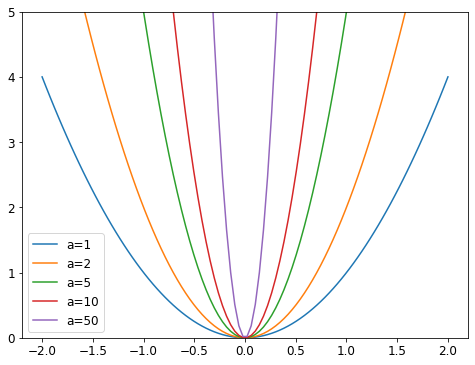

In [ ]:
#hide_input
#id parabolas
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots(figsize=(8,6))
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();

So, letting our model learn high parameters might cause it to fit all the data points in the training set with an overcomplex function that has very sharp changes, which will lead to overfitting.


因此，让我们的模型学习高参数可能会导致它用一个过度复杂的函数来拟合训练集中的所有数据点，这个函数有非常剧烈的变化，这将导致过度拟合。[机器翻译]

Limiting our weights from growing too much is going to hinder the training of the model, but it will yield a state where it generalizes better. Going back to the theory briefly, weight decay (or just `wd`) is a parameter that controls that sum of squares we add to our loss (assuming `parameters` is a tensor of all parameters):


限制我们的体重增长太多会阻碍模型的训练，但它会产生一种更好的概括状态。简单地回到理论，权重衰减 (或只是 “wd”) 是一个控制我们添加到损失中的平方和的参数 (假设 “参数” 是所有参数的张量):[机器翻译]

``` python
loss_with_wd = loss + wd * (parameters**2).sum()
```


''Python
Loss_with_wd = loss wd * (参数 * * 2).sum()
'''[机器翻译]

In practice, though, it would be very inefficient (and maybe numerically unstable) to compute that big sum and add it to the loss. If you remember a little bit of high schoool math, you might recall that the derivative of `p**2` with respect to `p` is `2*p`, so adding that big sum to our loss is exactly the same as doing:


然而，在实践中，计算这一大笔钱并将其添加到损失中是非常低效的 (可能在数字上不稳定)。如果你记得一点高中数学，你可能会记得 'p * * 2' 关于 'p' 的导数是 '2 * p'，因此，在我们的损失中增加这一大笔钱与做完全一样:[机器翻译]

``` python
parameters.grad += wd * 2 * parameters
```


''Python
Parameters.grad = wd * 2 * parameters
'''[机器翻译]

In practice, since `wd` is a parameter that we choose, we can just make it twice as big, so we don't even need the `*2` in this equation. To use weight decay in fastai, just pass `wd` in your call to `fit` or `fit_one_cycle`:


实际上，因为 “wd” 是我们选择的一个参数，我们可以把它放大两倍，所以我们甚至不需要这个等式中的 “* 2”。要在fastai中使用重量衰减，只需将 'wd' 传递给 'fit' 或 'fit_one_cycle':[机器翻译]

In [ ]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.972090,0.962366,00:13
1,0.875591,0.885106,00:13
2,0.723798,0.839880,00:13
3,0.586002,0.823225,00:13
4,0.490980,0.823060,00:13


Much better!


好多了![机器翻译]

### Creating Our Own Embedding Module


# 创建我们自己的嵌入模块[机器翻译]

So far, we've used `Embedding` without thinking about how it really works. Let's re-create `DotProductBias` *without* using this class. We'll need a randomly initialized weight matrix for each of the embeddings. We have to be careful, however. Recall from <<chapter_mnist_basics>> that optimizers require that they can get all the parameters of a module from the module's `parameters` method. However, this does not happen fully automatically. If we just add a tensor as an attribute to a `Module`, it will not be included in `parameters`:


到目前为止，我们已经使用了 “嵌入”，但没有考虑它实际上是如何工作的。让我们重新创建 “dotproductbias” * 而不 * 使用这个类。对于每个嵌入，我们需要一个随机初始化的权重矩阵。然而，我们必须小心。回想一下 <chapter_mnist_basics>>，优化器要求它们可以从模块的 “参数” 方法中获取模块的所有参数。然而，这并不是完全自动发生的。如果我们只是将张量作为属性添加到 “模块” 中，它将不会包含在 “参数” 中:[机器翻译]

In [ ]:
class T(Module):
    def __init__(self): self.a = torch.ones(3)

L(T().parameters())

(#0) []

To tell `Module` that we want to treat a tensor as a parameter, we have to wrap it in the `nn.Parameter` class. This class doesn't actually add any functionality (other than automatically calling `requires_grad_` for us). It's only used as a "marker" to show what to include in `parameters`:


要告诉 “模块” 我们想要将张量视为参数，我们必须将其包装在 “nn.parameter” 类中。这个类实际上没有添加任何功能 (除了为我们自动调用 'requires_grad _')。它仅用作 “标记” 来显示 “参数” 中包含的内容:[机器翻译]

In [ ]:
class T(Module):
    def __init__(self): self.a = nn.Parameter(torch.ones(3))

L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

All PyTorch modules use `nn.Parameter` for any trainable parameters, which is why we haven't needed to explicitly use this wrapper up until now:


所有PyTorch模块对任何可训练的参数都使用 'nn.Parameter'，这就是为什么我们到目前为止还不需要显式使用这个包装器:[机器翻译]

In [ ]:
class T(Module):
    def __init__(self): self.a = nn.Linear(1, 3, bias=False)

t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[-0.9595],
        [-0.8490],
        [ 0.8159]], requires_grad=True)]

In [ ]:
type(t.a.weight)

torch.nn.parameter.Parameter

We can create a tensor as a parameter, with random initialization, like so:


我们可以创建一个张量作为参数，随机初始化，就像这样:[机器翻译]

In [ ]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

Let's use this to create `DotProductBias` again, but without `Embedding`:


让我们使用它来再次创建 “dotproductbias”，但没有 “嵌入”:[机器翻译]

In [ ]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

Then let's train it again to check we get around the same results we saw in the previous section:


然后让我们再次训练它，以检查我们得到了与上一节中相同的结果:[机器翻译]

In [ ]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.962146,0.936952,00:14
1,0.858084,0.884951,00:14
2,0.740883,0.838549,00:14
3,0.592497,0.823599,00:14
4,0.473570,0.824263,00:14


Now, let's take a look at what our model has learned.


现在，让我们看看我们的模型学到了什么。[机器翻译]

## Interpreting Embeddings and Biases


# # 解释嵌入和偏见[机器翻译]

Our model is already useful, in that it can provide us with movie recommendations for our users—but it is also interesting to see what parameters it has discovered. The easiest to interpret are the biases. Here are the movies with the lowest values in the bias vector:


我们的模型已经很有用了，因为它可以为我们的用户提供电影推荐 -- 但是看看它发现了什么参数也很有趣。最容易解释的是偏见。以下是偏移向量中具有最低值的电影:[机器翻译]

In [ ]:
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Beautician and the Beast, The (1997)',
 'Crow: City of Angels, The (1996)',
 'Home Alone 3 (1997)']

Think about what this means. What it's saying is that for each of these movies, even when a user is very well matched to its latent factors (which, as we will see in a moment, tend to represent things like level of action, age of movie, and so forth), they still generally don't like it. We could have simply sorted the movies directly by their average rating, but looking at the learned bias tells us something much more interesting. It tells us not just whether a movie is of a kind that people tend not to enjoy watching, but that people tend not to like watching it even if it is of a kind that they would otherwise enjoy! By the same token, here are the movies with the highest bias:


想想这意味着什么。它的意思是，对于这些电影中的每一部，即使用户与它的潜在因素非常匹配 (正如我们稍后将看到的，倾向于代表动作水平、电影时代等等)，他们仍然普遍不喜欢。我们本可以简单地根据电影的平均评分直接对它们进行排序，但是看看学习上的偏见会告诉我们一些更有趣的事情。它不仅告诉我们一部电影是否是人们不喜欢看的那种，但是人们往往不喜欢看它，即使它是他们本来会喜欢的那种!同样，以下是偏见最高的电影:[机器翻译]

In [ ]:
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['L.A. Confidential (1997)',
 'Titanic (1997)',
 'Silence of the Lambs, The (1991)',
 'Shawshank Redemption, The (1994)',
 'Star Wars (1977)']

So, for instance, even if you don't normally enjoy detective movies, you might enjoy *LA Confidential*!


所以，例如，即使你通常不喜欢侦探电影，你也可能会喜欢 * LA Confidential *![机器翻译]

It is not quite so easy to directly interpret the embedding matrices. There are just too many factors for a human to look at. But there is a technique that can pull out the most important underlying *directions* in such a matrix, called *principal component analysis* (PCA). We will not be going into this in detail in this book, because it is not particularly important for you to understand to be a deep learning practitioner, but if you are interested then we suggest you check out the fast.ai course [Computational Linear Algebra for Coders](https://github.com/fastai/numerical-linear-algebra). <<img_pca_movie>> shows what our movies look like based on two of the strongest PCA components.


直接解释嵌入矩阵并不容易。对于一个人来说，有太多的因素要看。但是有一种技术可以在这样的矩阵中提取最重要的基础 * 方向 *，称为 * 主成分分析 * (PCA)。我们不会在这本书里详细讨论这个问题，因为理解成为一个深度学习的实践者并不特别重要，但是如果你感兴趣，我们建议你去快速看看。ai课程【编码员的计算线性代数】 ( https://github.com/fastai/numerical-linear-algebra )。<<Img_pca_movie>> 基于两个最强的PCA组件显示了我们的电影的外观。[机器翻译]

In [1]:
#hide_input
#id img_pca_movie
#caption Representation of movies based on two strongest PCA components
#alt Representation of movies based on two strongest PCA components
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

We can see here that the model seems to have discovered a concept of *classic* versus *pop culture* movies, or perhaps it is *critically acclaimed* that is represented here.


我们在这里可以看到，这个模型似乎发现了一个 * 经典 * 对 * 流行文化 * 电影的概念，或者可能是这里所代表的 * 广受好评的 *。[机器翻译]

> j: No matter how many models I train, I never stop getting moved and surprised by how these randomly initialized bunches of numbers, trained with such simple mechanics, manage to discover things about my data all by themselves. It almost seems like cheating, that I can create code that does useful things without ever actually telling it how to do those things!


> J: 不管我训练了多少个模型，我都不会停止移动，也不会惊讶于这些随机初始化的数字束是如何用如此简单的力学训练的，设法自己发现有关我的数据的东西。这几乎就像作弊一样，我可以创建做有用事情的代码，而不必告诉它如何做这些事情![机器翻译]

We defined our model from scratch to teach you what is inside, but you can directly use the fastai library to build it. We'll look at how to do that next.


我们从零开始定义我们的模型来教你里面是什么，但是你可以直接使用fastai库来构建它。我们将考虑下一步如何做。[机器翻译]

### Using fastai.collab


# 使用fastai.collab[机器翻译]

We can create and train a collaborative filtering model using the exact structure shown earlier by using fastai's `collab_learner`:


通过使用fastai的 'collab_learner'，我们可以使用前面显示的确切结构创建和训练协作过滤模型:[机器翻译]

In [ ]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [ ]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.931751,0.953806,00:13
1,0.851826,0.878119,00:13
2,0.715254,0.834711,00:13
3,0.583173,0.821470,00:13
4,0.496625,0.821688,00:13


The names of the layers can be seen by printing the model:


通过打印模型可以看到层的名称:[机器翻译]

In [ ]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1635, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1635, 1)
)

We can use these to replicate any of the analyses we did in the previous section—for instance:


我们可以使用这些来复制我们在上一节中所做的任何分析-例如:[机器翻译]

In [ ]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 "Schindler's List (1993)",
 'Shawshank Redemption, The (1994)',
 'L.A. Confidential (1997)',
 'Silence of the Lambs, The (1991)']

Another interesting thing we can do with these learned embeddings is to look at _distance_.


我们可以用这些学到的嵌入做的另一件有趣的事情是看 _ distance _。[机器翻译]

### Embedding Distance


# 嵌入距离[机器翻译]

On a two-dimensional map we can calculate the distance between two coordinates using the formula of Pythagoras: $\sqrt{x^{2}+y^{2}}$ (assuming that *x* and *y* are the distances between the coordinates on each axis). For a 50-dimensional embedding we can do exactly the same thing, except that we add up the squares of all 50 of the coordinate distances.


在二维地图上，我们可以使用毕达哥拉斯公式计算两个坐标之间的距离: $ \ sqrt{x ^{2} y ^{2}}$ (假设 * x * 和 * y * 是每个轴上坐标之间的距离)。对于50维嵌入，我们可以做完全相同的事情，除了我们将所有50个坐标距离的平方相加。[机器翻译]

If there were two movies that were nearly identical, then their embedding vectors would also have to be nearly identical, because the users that would like them would be nearly exactly the same. There is a more general idea here: movie similarity can be defined by the similarity of users that like those movies. And that directly means that the distance between two movies' embedding vectors can define that similarity. We can use this to find the most similar movie to *Silence of the Lambs*:


如果有两部电影几乎相同，那么它们的嵌入向量也必须几乎相同，因为想要它们的用户几乎完全相同。这里有一个更一般的想法: 电影相似性可以通过喜欢那些电影的用户的相似性来定义。这直接意味着两个电影嵌入向量之间的距离可以定义这种相似性。我们可以用这个找到与 * 沉默的羔羊 * 最相似的电影:[机器翻译]

In [ ]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Dial M for Murder (1954)'

Now that we have succesfully trained a model, let's see how to deal with the situation where we have no data for a user. How can we make recommendations to new users?


现在我们已经成功地训练了一个模型，让我们看看如何处理没有用户数据的情况。我们如何向新用户推荐？[机器翻译]

## Bootstrapping a Collaborative Filtering Model


# # 引导协作过滤模型[机器翻译]

The biggest challenge with using collaborative filtering models in practice is the *bootstrapping problem*. The most extreme version of this problem is when you have no users, and therefore no history to learn from. What products do you recommend to your very first user?


在实践中使用协同过滤模型的最大挑战是 * 引导问题 *。这个问题最极端的版本是当你没有用户，因此没有历史可以学习。你向你的第一个用户推荐什么产品？[机器翻译]

But even if you are a well-established company with a long history of user transactions, you still have the question: what do you do when a new user signs up? And indeed, what do you do when you add a new product to your portfolio? There is no magic solution to this problem, and really the solutions that we suggest are just variations of *use your common sense*. You could assign new users the mean of all of the embedding vectors of your other users, but this has the problem that that particular combination of latent factors may be not at all common (for instance, the average for the science-fiction factor may be high, and the average for the action factor may be low, but it is not that common to find people who like science-fiction without action). Better would probably be to pick some particular user to represent *average taste*.


但是，即使你是一家有着悠久用户交易历史的老牌公司，你仍然有一个问题: 当一个新用户注册时，你会做什么？事实上，当你向你的产品组合中添加新产品时，你会怎么做？这个问题没有神奇的解决方案，我们建议的解决方案实际上只是 * 使用你的常识 * 的变体。您可以为新用户分配其他用户的所有嵌入向量的平均值，但这有一个问题，即潜在因素的特定组合可能根本不常见 (例如，科幻因素的平均值可能很高，行动因素的平均值可能很低，但发现喜欢没有行动的科幻小说的人并不常见)。更好的可能是选择一些特定的用户来代表 * 平均口味 *。[机器翻译]

Better still is to use a tabular model based on user meta data to construct your initial embedding vector. When a user signs up, think about what questions you could ask them that could help you to understand their tastes. Then you can create a model where the dependent variable is a user's embedding vector, and the independent variables are the results of the questions that you ask them, along with their signup metadata. We will see in the next section how to create these kinds of tabular models. (You may have noticed that when you sign up for services such as Pandora and Netflix, they tend to ask you a few questions about what genres of movie or music you like; this is how they come up with your initial collaborative filtering recommendations.)


更好的是使用基于用户元数据的表格模型来构建您的初始嵌入向量。当用户注册时，想想你可以问他们哪些问题来帮助你理解他们的品味。然后，您可以创建一个模型，其中因变量是用户的嵌入向量，独立变量是您向他们提出的问题的结果，以及他们的注册元数据。我们将在下一节中看到如何创建这些类型的表格模型。(你可能已经注意到，当你注册潘多拉和网飞等服务时，他们会问你一些关于你喜欢哪种类型的电影或音乐的问题; 这就是他们如何提出您的初始协作过滤建议。)[机器翻译]

One thing to be careful of is that a small number of extremely enthusiastic users may end up effectively setting the recommendations for your whole user base. This is a very common problem, for instance, in movie recommendation systems. People that watch anime tend to watch a whole lot of it, and don't watch very much else, and spend a lot of time putting their ratings on websites. As a result, anime tends to be heavily overrepresented in a lot of *best ever movies* lists. In this particular case, it can be fairly obvious that you have a problem of representation bias, but if the bias is occurring in the latent factors then it may not be obvious at all.


需要注意的一点是，少数极度热情的用户最终可能会有效地为你的整个用户群设置建议。这是一个非常常见的问题，例如，在电影推荐系统中。看动画的人倾向于看很多，其他的不看太多，花很多时间把他们的收视率放在网站上。因此，动画在许多有史以来最好的电影列表中所占比例往往过高。在这种特殊的情况下，很明显你有一个代表性偏见的问题，但是如果偏见发生在潜在的因素中，那么它可能一点也不明显。[机器翻译]

Such a problem can change the entire makeup of your user base, and the behavior of your system. This is particularly true because of positive feedback loops. If a small number of your users tend to set the direction of your recommendation system, then they are naturally going to end up attracting more people like them to your system. And that will, of course, amplify the original representation bias. This type of bias has a natural tendency to be amplified exponentially. You may have seen examples of company executives expressing surprise at how their online platforms rapidly deteriorated in such a way that they expressed values at odds with the values of the founders. In the presence of these kinds of feedback loops, it is easy to see how such a divergence can happen both quickly and in a way that is hidden until it is too late.


这样的问题可能会改变你的用户群的整个组成，以及你的系统的行为。尤其如此，因为正反馈回路。如果你的一小部分用户倾向于设定你推荐系统的方向，那么他们自然会吸引更多像他们一样的人加入你的系统。当然，这将放大原始的表示偏差。这种类型的偏见有被指数放大的自然趋势。你可能已经看到一些公司高管对他们的在线平台如何迅速恶化表示惊讶的例子，他们表达的价值观与创始人的价值观不一致。在这种反馈回路存在的情况下，很容易看出这种发散是如何快速发生的，并且以一种隐藏的方式发生，直到为时已晚。[机器翻译]

In a self-reinforcing system like this, we should probably expect these kinds of feedback loops to be the norm, not the exception. Therefore, you should assume that you will see them, plan for that, and identify up front how you will deal with these issues. Try to think about all of the ways in which feedback loops may be represented in your system, and how you might be able to identify them in your data. In the end, this is coming back to our original advice about how to avoid disaster when rolling out any kind of machine learning system. It's all about ensuring that there are humans in the loop; that there is careful monitoring, and a gradual and thoughtful rollout.


在像这样的自我强化系统中，我们可能应该期望这些反馈回路成为常态，而不是例外。因此，你应该假设你会看到他们，为此做好计划，并预先确定你将如何处理这些问题。试着考虑反馈回路在你的系统中可能被表示的所有方式，以及你如何能够在你的数据中识别它们。最后，这回到了我们最初的建议，即在推出任何类型的机器学习系统时如何避免灾难。这一切都是为了确保循环中有人类; 有仔细的监控，以及渐进和深思熟虑的推广。[机器翻译]

Our dot product model works quite well, and it is the basis of many successful real-world recommendation systems. This approach to collaborative filtering is known as *probabilistic matrix factorization* (PMF). Another approach, which generally works similarly well given the same data, is deep learning.


我们的dot产品模型运行得相当好，它是许多成功的真实世界推荐系统的基础。这种协同过滤方法被称为 * 概率矩阵分解 * (PMF)。另一种方法是深度学习，在给定相同数据的情况下，这种方法通常同样有效。[机器翻译]

## Deep Learning for Collaborative Filtering


# # 深度学习用于协作过滤[机器翻译]

To turn our architecture into a deep learning model, the first step is to take the results of the embedding lookup and concatenate those activations together. This gives us a matrix which we can then pass through linear layers and nonlinearities in the usual way.


要将我们的架构转变为深度学习模型，第一步是获取嵌入查找的结果，并将这些激活连接在一起。这给了我们一个矩阵，然后我们可以以通常的方式通过线性层和非线性。[机器翻译]

Since we'll be concatenating the embedding matrices, rather than taking their dot product, the two embedding matrices can have different sizes (i.e., different numbers of latent factors). fastai has a function `get_emb_sz` that returns recommended sizes for embedding matrices for your data, based on a heuristic that fast.ai has found tends to work well in practice:


因为我们将连接嵌入矩阵，而不是取它们的点积，所以两个嵌入矩阵可以有不同的大小 (即不同数量的潜在因子)。Fastai有一个函数 'get_emb_sz'，它根据快速的启发式方法返回嵌入矩阵的推荐大小。ai发现在实践中往往工作得很好:[机器翻译]

In [ ]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1635, 101)]

Let's implement this class:


让我们实现这个类:[机器翻译]

In [ ]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

And use it to create a model:


并使用它创建一个模型:[机器翻译]

In [ ]:
model = CollabNN(*embs)

`CollabNN` creates our `Embedding` layers in the same way as previous classes in this chapter, except that we now use the `embs` sizes. `self.layers` is identical to the mini-neural net we created in <<chapter_mnist_basics>> for MNIST. Then, in `forward`, we apply the embeddings, concatenate the results, and pass this through the mini-neural net. Finally, we apply `sigmoid_range` as we have in previous models.


“Collabnn” 创建我们的 “嵌入” 层的方式与本章中以前的类相同，只是我们现在使用 “embs” 大小。'Self.Layer' 与我们在 <chapter_mnist_basics>> 中为MNIST创建的迷你神经网络相同。然后，在 “前进” 中，我们应用嵌入，连接结果，并通过迷你神经网络传递。最后，我们应用 “sigmoid_range”，就像我们在以前的模型中一样。[机器翻译]

Let's see if it trains:


让我们看看它是否训练:[机器翻译]

In [ ]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.940104,0.959786,00:15
1,0.893943,0.905222,00:14
2,0.865591,0.875238,00:14
3,0.800177,0.867468,00:14
4,0.760255,0.867455,00:14


fastai provides this model in `fastai.collab` if you pass `use_nn=True` in your call to `collab_learner` (including calling `get_emb_sz` for you), and it lets you easily create more layers. For instance, here we're creating two hidden layers, of size 100 and 50, respectively:


Fastai在 'fastai' 中提供此模型。collab '如果您在对' collab_learner '的调用中传递' use_nn = true '(包括为您调用' get_emb_sz ')，它可以让您轻松创建更多层。例如，我们在这里创建了两个大小分别为100和50的隐藏层:[机器翻译]

In [ ]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,1.002747,0.972392,00:16
1,0.926903,0.922348,00:16
2,0.877160,0.893401,00:16
3,0.838334,0.865040,00:16
4,0.781666,0.864936,00:16


`learn.model` is an object of type `EmbeddingNN`. Let's take a look at fastai's code for this class:


'Learn.Model' 是 'embeddingnn' 类型的对象。让我们看看fastai为这个类编写的代码:[机器翻译]

In [ ]:
@delegates(TabularModel)
class EmbeddingNN(TabularModel):
    def __init__(self, emb_szs, layers, **kwargs):
        super().__init__(emb_szs, layers=layers, n_cont=0, out_sz=1, **kwargs)

Wow, that's not a lot of code! This class *inherits* from `TabularModel`, which is where it gets all its functionality from. In `__init__` it calls the same method in `TabularModel`, passing `n_cont=0` and `out_sz=1`; other than that, it only passes along whatever arguments it received.


哇，那不是很多代码!这个类 * 从 “tabularmodel” 继承 *，这是它获取所有功能的地方。在 '_ _ init _ _' 中，它在 'tabularmodel' 中调用相同的方法，传递 'n_cont = 0' 和 'out_sz = 1'; 除此之外，它只传递它收到的任何参数。[机器翻译]

### Sidebar: kwargs and Delegates


# 侧栏: kwargs和代表[机器翻译]

`EmbeddingNN` includes `**kwargs` as a parameter to `__init__`. In Python `**kwargs` in a parameter list means "put any additional keyword arguments into a dict called `kwargs`. And `**kwargs` in an argument list means "insert all key/value pairs in the `kwargs` dict as named arguments here". This approach is used in many popular libraries, such as `matplotlib`, in which the main `plot` function simply has the signature `plot(*args, **kwargs)`. The [`plot` documentation](https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.plot) says "The `kwargs` are `Line2D` properties" and then lists those properties.


'Embeddingnn' 包括 '* * kwargs' 作为 '_ _ init _ _' 的参数。在Python中，参数列表中的 '* * kwargs' 意味着 “将任何额外的关键字参数放入名为 'kwargs' 的dict中。参数列表中的 '* * kwargs' 表示 “在 'kwargs' 字典中插入所有键/值对作为此处的命名参数”。这种方法在许多流行的库中使用，例如 'matplotlib'，其中主 'plot' 函数仅具有签名 'plot(* args，* * kwargs)'。['Plot' 文档] ( https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.plot ) 说 “kwargs” 是 “Line2D” 属性，然后列出这些属性。[机器翻译]

We're using `**kwargs` in `EmbeddingNN` to avoid having to write all the arguments to `TabularModel` a second time, and keep them in sync. However, this makes our API quite difficult to work with, because now Jupyter Notebook doesn't know what parameters are available. Consequently things like tab completion of parameter names and pop-up lists of signatures won't work.


我们在 “嵌入” 中使用 “* * kwargs”，以避免第二次将所有参数写入 “tabularmodel”，并保持它们同步。然而，这使得我们的API很难使用，因为现在Jupyter Notebook不知道哪些参数可用。因此，参数名称的选项卡完成和签名的弹出列表之类的东西将不起作用。[机器翻译]

fastai resolves this by providing a special `@delegates` decorator, which automatically changes the signature of the class or function (`EmbeddingNN` in this case) to insert all of its keyword arguments into the signature.


Fastai通过提供一个特殊的 “@ deleges” 装饰器来解决这个问题，它会自动更改类或函数的签名 (在本例中为 “嵌入”)，以便将其所有关键字参数插入到签名中。[机器翻译]

### End sidebar


# 结束侧边栏[机器翻译]

Although the results of `EmbeddingNN` are a bit worse than the dot product approach (which shows the power of carefully constructing an architecture for a domain), it does allow us to do something very important: we can now directly incorporate other user and movie information, date and time information, or any other information that may be relevant to the recommendation. That's exactly what `TabularModel` does. In fact, we've now seen that `EmbeddingNN` is just a `TabularModel`, with `n_cont=0` and `out_sz=1`. So, we'd better spend some time learning about `TabularModel`, and how to use it to get great results! We'll do that in the next chapter.


虽然 “嵌入” 的结果比点产品方法 (这显示了为领域精心构建架构的能力) 差一点，但它确实允许我们做一些非常重要的事情: 我们现在可以直接合并其他用户和电影信息，日期和时间信息，或可能与建议相关的任何其他信息。这正是 “tabularmodel” 所做的。事实上，我们现在已经看到 'embeddingnn' 只是一个 'tabularmodel'，具有 'n_cont = 0' 和 'out_sz = 1'。所以，我们最好花些时间学习 “tabularmodel”，以及如何使用它来获得好的结果!我们将在下一章这样做。[机器翻译]

## Conclusion


# # 结论[机器翻译]

For our first non-computer vision application, we looked at recommendation systems and saw how gradient descent can learn intrinsic factors or biases about items from a history of ratings. Those can then give us information about the data. 


对于我们的第一个非计算机视觉应用，我们查看了推荐系统，并了解了梯度下降如何从评级历史中了解项目的内在因素或偏见。然后，这些可以向我们提供有关数据的信息。[机器翻译]

We also built our first model in PyTorch. We will do a lot more of this in the next section of the book, but first, let's finish our dive into the other general applications of deep learning, continuing with tabular data.


我们还在PyTorch中构建了我们的第一个模型。我们将在本书的下一部分做更多的工作，但是首先，让我们继续学习表格数据，深入了解深度学习的其他一般应用。[机器翻译]

## Questionnaire


# # 问卷调查[机器翻译]

1. What problem does collaborative filtering solve?
1. How does it solve it?
1. Why might a collaborative filtering predictive model fail to be a very useful recommendation system?
1. What does a crosstab representation of collaborative filtering data look like?
1. Write the code to create a crosstab representation of the MovieLens data (you might need to do some web searching!).
1. What is a latent factor? Why is it "latent"?
1. What is a dot product? Calculate a dot product manually using pure Python with lists.
1. What does `pandas.DataFrame.merge` do?
1. What is an embedding matrix?
1. What is the relationship between an embedding and a matrix of one-hot-encoded vectors?
1. Why do we need `Embedding` if we could use one-hot-encoded vectors for the same thing?
1. What does an embedding contain before we start training (assuming we're not using a pretained model)?
1. Create a class (without peeking, if possible!) and use it.
1. What does `x[:,0]` return?
1. Rewrite the `DotProduct` class (without peeking, if possible!) and train a model with it.
1. What is a good loss function to use for MovieLens? Why? 
1. What would happen if we used cross-entropy loss with MovieLens? How would we need to change the model?
1. What is the use of bias in a dot product model?
1. What is another name for weight decay?
1. Write the equation for weight decay (without peeking!).
1. Write the equation for the gradient of weight decay. Why does it help reduce weights?
1. Why does reducing weights lead to better generalization?
1. What does `argsort` do in PyTorch?
1. Does sorting the movie biases give the same result as averaging overall movie ratings by movie? Why/why not?
1. How do you print the names and details of the layers in a model?
1. What is the "bootstrapping problem" in collaborative filtering?
1. How could you deal with the bootstrapping problem for new users? For new movies?
1. How can feedback loops impact collaborative filtering systems?
1. When using a neural network in collaborative filtering, why can we have different numbers of factors for movies and users?
1. Why is there an `nn.Sequential` in the `CollabNN` model?
1. What kind of model should we use if we want to add metadata about users and items, or information such as date and time, to a collaborative filtering model?


1.协同过滤解决什么问题？
1.它如何解决它？
1.为什么协同过滤预测模型可能不能成为非常有用的推荐系统？
1.协同过滤数据的交叉表表示是什么样子的？
1.编写代码以创建MovieLens数据的交叉表表示 (您可能需要进行一些web搜索!)。
1.什么是潜在因素？为什么是 “潜伏”？
1.什么是点积？使用带列表的纯Python手动计算点积。
1.Pandas.DataFrame.Merge是做什么的？
1.什么是嵌入矩阵？
1.嵌入和一个热编码向量的矩阵之间的关系是什么？
1.如果我们可以为同一件事使用一热编码向量，为什么我们需要 “嵌入”？
1.在我们开始训练之前，嵌入包含什么 (假设我们没有使用预先获得的模型)？
1.创建一个类 (不偷看，如果可能的话!) 并使用它。
1.'x[:，0]' 返回什么？
1.重写 “dotproduct” 类 (如果可能的话，不偷看!) 并使用它训练模型。
1.MovieLens使用什么是好的损失函数？为什么？
1.如果我们使用与MovieLens的交叉熵损失会发生什么？我们需要如何改变模型？
1.偏差在点积模型中有什么用？
1.体重衰减的另一个名称是什么？
1.写体重衰减的方程 (不偷看!)。
1.写权重衰减梯度的方程。为什么它有助于减轻体重？
1.为什么减少权重会导致更好的泛化？
1.'argsort' 在PyTorch中做什么？
1.对电影偏见进行排序是否会产生与按电影平均总体电影评分相同的结果？为什么/为什么不呢？
1.如何打印模型中图层的名称和细节？
1.什么是协同过滤中的 “自举问题”？
1.你如何处理新用户的自举问题？为了新电影？
1.反馈回路如何影响协同过滤系统？
1.在协同过滤中使用神经网络时，为什么我们可以对电影和用户有不同数量的因素？
1.为什么在 “collabnn” 模型中存在 “nn.Sequential”？
1.如果我们想将关于用户和项目的元数据，或者日期和时间等信息添加到协作过滤模型中，我们应该使用什么样的模型？[机器翻译]

### Further Research


# 进一步研究[机器翻译]

1. Take a look at all the differences between the `Embedding` version of `DotProductBias` and the `create_params` version, and try to understand why each of those changes is required. If you're not sure, try reverting each change to see what happens. (NB: even the type of brackets used in `forward` has changed!)
1. Find three other areas where collaborative filtering is being used, and find out what the pros and cons of this approach are in those areas.
1. Complete this notebook using the full MovieLens dataset, and compare your results to online benchmarks. See if you can improve your accuracy. Look on the book's website and the fast.ai forum for ideas. Note that there are more columns in the full dataset—see if you can use those too (the next chapter might give you ideas).
1. Create a model for MovieLens that works with cross-entropy loss, and compare it to the model in this chapter.


1.看看 “dotproductbias” 的 “嵌入” 版本和 “create_params” 版本之间的所有差异，并尝试理解为什么需要这些更改。如果您不确定，请尝试恢复每个更改以查看发生了什么。(注意: “前进” 中使用的括号类型已经改变了!)
1.找到其他三个使用协作过滤的领域，并找出这种方法在这些领域的优缺点。
1.使用完整的MovieLens数据集完成此笔记本，并将结果与在线基准进行比较。看看你能否提高你的准确性。在这本书的网站和fast.ai论坛上寻找想法。请注意，完整的数据集中有更多的列 -- 看看你是否也可以使用这些列 (下一章可能会给你一些想法)。
1.为MovieLens创建一个使用交叉熵损失的模型，并将其与本章中的模型进行比较。[机器翻译]